In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):    
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [ ]:
import copy
import torch
from torch.autograd import Variable
import random
import math
import torchvision.transforms as T
import numpy as np
import time
import torch.nn as nn

class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = nn.MSELoss()
            self.model = nn.Sequential(*[nn.Linear(state_dim, hidden_dim),
                                         nn.LeakyReLU(),
                                         nn.Linear(hidden_dim, action_dim)])
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        # your code here
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
    def replay(self, size, gamma):
      if len(self.memory)<size:
        return
      batch = random.sample(self.memory, size)

      batch_t = list(map(list, zip(*batch)))
      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      reward = torch.Tensor(batch_t[3])
      is_done = torch.LongTensor(batch_t[4])
      all_q_values = self.predict(states)
      all_q_values_next = self.predict(next_states)
      all_q_values[range(len(all_q_values)), actions] = rewards + (1-is_done)*gamma*torch.max(all_q_values_next)
      self.update(states.tolist(), all_q_values.tolist())



DQN

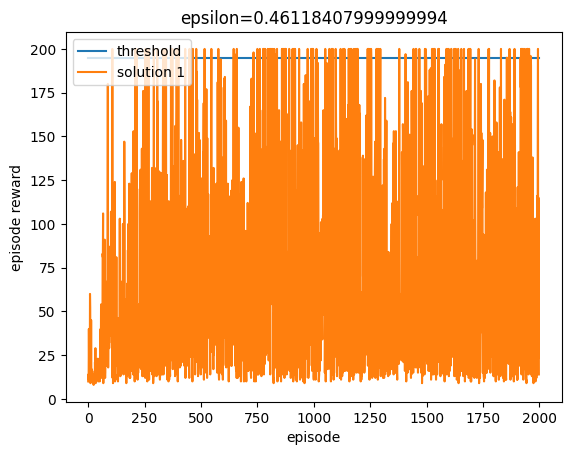

done


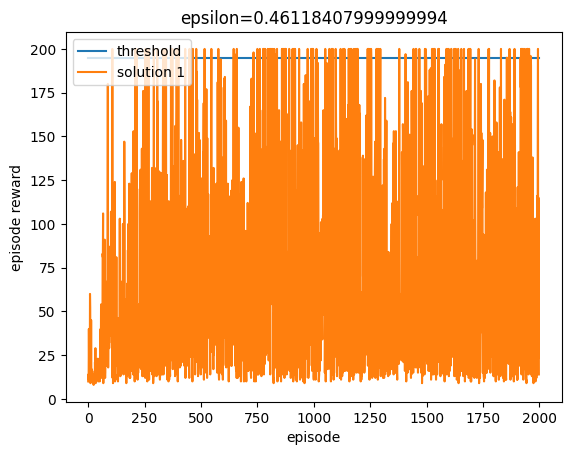

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # greedy threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
n_hidden = 8
model = DQN(n_states, n_actions, n_hidden, alpha)

#
memory = []
replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation
    #
    
    if i_episode > 50 and (i_episode + 1) % 500 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.98

        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        q_values = model.predict(state)
        
        if np.random.random_sample() < epsilon: 
            action = env.action_space.sample() 
        else:
            action = torch.argmax(q_values).item()
        
        observation, reward, done, info = env.step(action)
        
        rewards += reward
        next_state = observation
        memory.append((state, action, next_state, reward, done))
        
        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            q_values[action] = reward
            model.update(state, q_values)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
            
        # Update Q-network
        # your code here
        q_values_next = model.predict(next_state)
        q_values[action] = reward + gamma*torch.max(q_values_next).item()
        model.update(state, q_values)
        # Update current state 
        state = next_state
        
    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")

DQN + scheduler

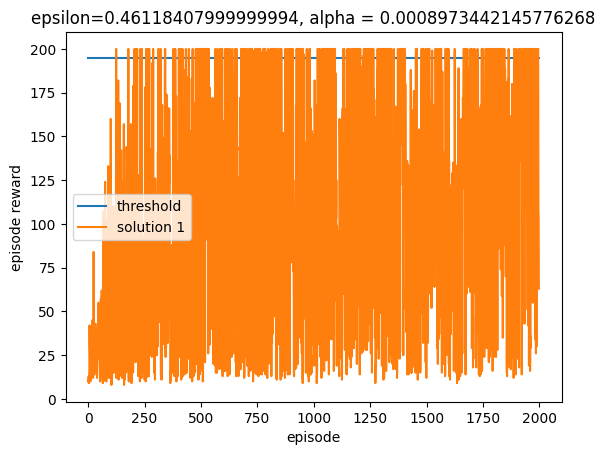

done


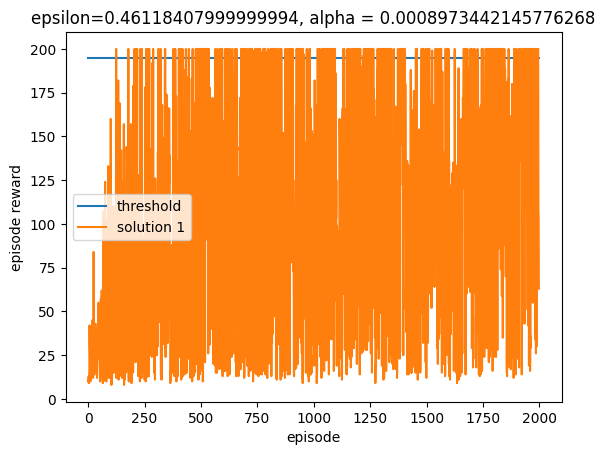

In [ ]:
import gym, math
import numpy as np
from torch.optim.lr_scheduler import StepLR

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # greedy threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
n_hidden = 8
model = DQN(n_states, n_actions, n_hidden, alpha)
scheduler = StepLR(model.optimizer, 
                   step_size = 10, # Period of learning rate decay
                   gamma = 0.98) 
#
memory = []
replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation
    #
    
    if i_episode > 50 and (i_episode + 1) % 500 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.98

        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}, alpha = {}'.format(epsilon,model.optimizer.param_groups[0]["lr"]))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        q_values = model.predict(state)
        
        if np.random.random_sample() < epsilon: 
            action = env.action_space.sample() 
        else:
            action = torch.argmax(q_values).item()
        
        observation, reward, done, info = env.step(action)
        
        rewards += reward
        next_state = observation
        memory.append((state, action, next_state, reward, done))
        
        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            q_values[action] = reward
            model.update(state, q_values)
            scheduler.step()  
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
            
        # Update Q-network
        # your code here
        q_values_next = model.predict(next_state)
        q_values[action] = reward + gamma*torch.max(q_values_next).item()
        model.update(state, q_values)
        #scheduler.step()  
        # Update current state 
        state = next_state
        
    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")

DQN + Replay

In [ ]:
class DQN_with_replay():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion =torch.nn.MSELoss()
            self.model =torch.nn.Sequential(
                torch.nn.Linear(state_dim,hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim,action_dim)        
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(),alpha)
            self.scheduler=torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=50,gamma=0.9)
          
            self.losses = []
            self.memory=  []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self,size,gamma):
      if len(self.memory)<size:
        return

      batch=random.sample(self.memory,size)

      batch_t=list(map(list,zip(*batch)))

      states=torch.Tensor(batch_t[0])
      actions=torch.LongTensor(batch_t[1])
      next_states=torch.Tensor(batch_t[2])
      rewards=torch.Tensor(batch_t[3])
      is_done=torch.LongTensor(batch_t[4])

      all_q_values=self.predict(states)
      all_q_values_next=self.predict(next_states)

      
      all_q_values[range(len(all_q_values)),actions]=rewards+gamma*(1-is_done)*torch.max(all_q_values_next,axis=1).values

      self.update(states.tolist(),all_q_values.tolist())

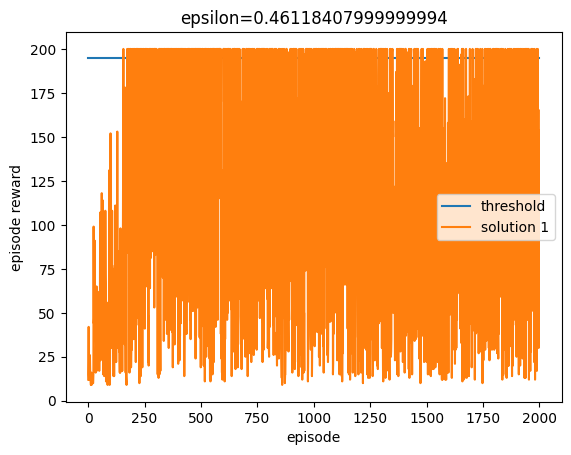

done


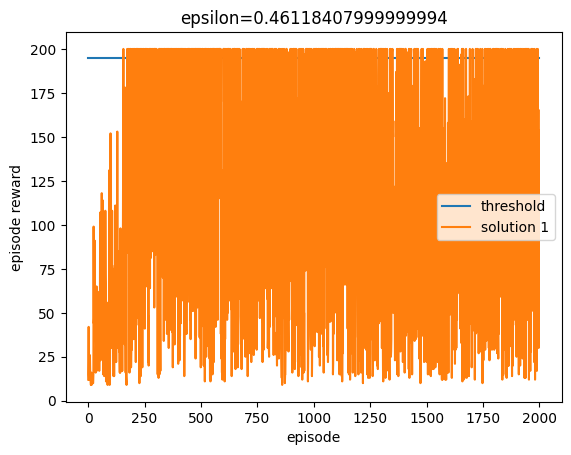

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # greedy threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
n_hidden = 8

replay_size = 50
model_with_replay = DQN_with_replay(n_states, n_actions, n_hidden, alpha)

#
memory = []
replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation
    #
    
    if i_episode > 50 and (i_episode + 1) % 500 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.98

        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        q_values = model_with_replay.predict(state)
        
        if np.random.random_sample() < epsilon: 
            action = env.action_space.sample() 
        else:
            action = torch.argmax(q_values).item()
        
        observation, reward, done, info = env.step(action)
        
        rewards += reward
        next_state = observation
        model_with_replay.memory.append((state, action, next_state, reward, done))
        
        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if len(model_with_replay.memory) <replay_size:
              q_values[action] = reward
              model_with_replay.update(state, q_values)
            else:
              model_with_replay.replay(replay_size, gamma)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
            
        # Update Q-network
        # your code here
        if len(model_with_replay.memory) <replay_size:
            q_values[action] = reward
            q_values[action]=reward+ gamma*torch.max(q_values_next).item()
            model_with_replay.update(state, q_values)
        else:
            model_with_replay.replay(replay_size, gamma)
        # Update current state 
        state = next_state
        
            

print("done")

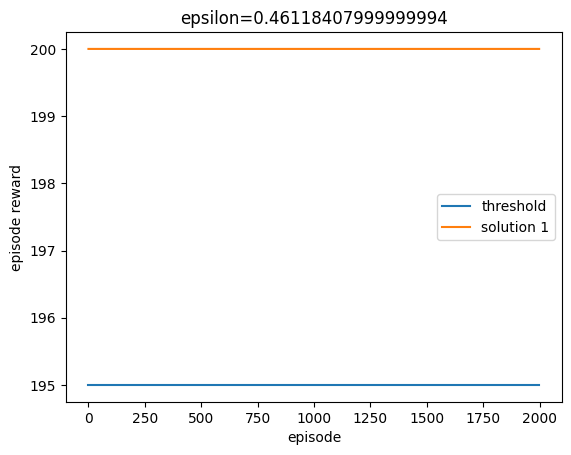

done


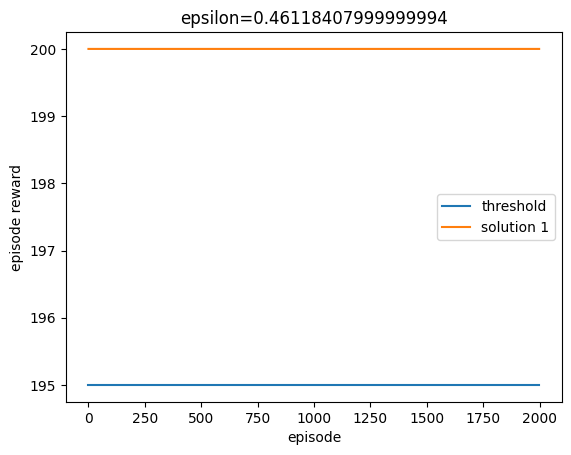

In [ ]:
# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation
    #
    
    if i_episode > 50 and (i_episode + 1) % 500 == 0 and epsilon > 0.01:

        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        q_values = model_with_replay.predict(state)
        action = torch.argmax(q_values).item() 
        observation, reward, done, info = env.step(action)
        
        rewards += reward
        next_state = observation
        memory.append((state, action, next_state, reward, done))
        
        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t

            break

        state = next_state

            

print("done")

DQN + Target

In [ ]:
import copy
import torch
from torch.autograd import Variable
import random
import math
import torchvision.transforms as T
import numpy as np
import time
import torch.nn as nn

class DQN_with_replay_and_tn():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion =torch.nn.MSELoss()
            self.model =torch.nn.Sequential(
                torch.nn.Linear(state_dim,hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim,action_dim)        
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(),alpha)
            self.scheduler=torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=50,gamma=0.9)
            self.losses = []
            self.memory=  []
    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.losses.append(loss.detach().numpy())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def replay(self,tmodel,size,gamma):
      if len(self.memory)<size:
        return
      batch=random.sample(self.memory,size)
      batch_t=list(map(list,zip(*batch)))
      states=torch.Tensor(batch_t[0])
      actions=torch.LongTensor(batch_t[1])
      next_states=torch.Tensor(batch_t[2])
      rewards=torch.Tensor(batch_t[3])
      is_done=torch.LongTensor(batch_t[4])
      all_q_values=tmodel.predict(states)
      all_q_values_next=tmodel.predict(next_states)
      all_q_values[range(len(all_q_values)),actions]=rewards+gamma*(1-is_done)*torch.max(all_q_values_next,axis=1).values

      self.update(states.tolist(),all_q_values.tolist())


In [ ]:
import copy
class TDQN():
  def __init__(self, dqn):
    self.model = copy.deepcopy(dqn.model)
    self.dqn = dqn

  def update(self):
    parameters = self.dqn.model.state_dict()
    self.model.load_state_dict(parameters)
  
  def predict(self, state):
    with torch.no_grad():
            return self.model(torch.Tensor(state))

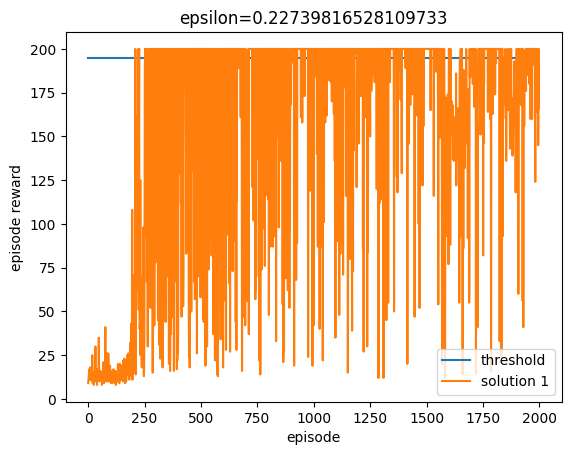

done


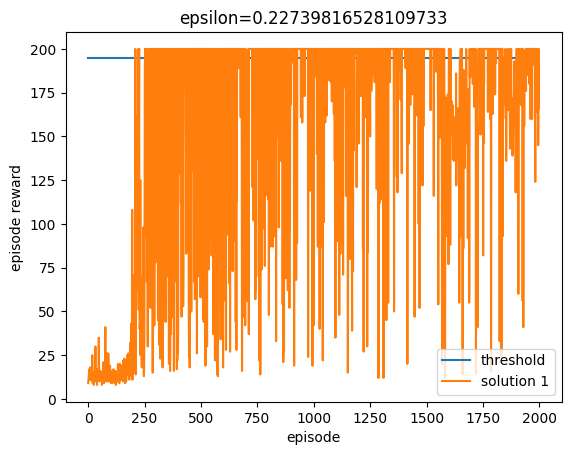

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # greedy threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
n_hidden = 8

replay_size = 50
model_with_tn = DQN_with_replay_and_tn(n_states, n_actions, n_hidden, alpha)
tmodel = TDQN(model_with_tn)
#
memory = []
#replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation
    #
    
    if i_episode > 50 and (i_episode + 1) % 50 == 0 and epsilon > 0.01:
        epsilon = epsilon*0.98
    if i_episode > 50 and (i_episode + 1) % 10 == 0:
        tmodel.update()
    if i_episode > 50 and (i_episode + 1) % 50 == 0 :
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        q_values = model_with_tn.predict(state)
        
        if np.random.random_sample() < epsilon: 
            action = env.action_space.sample() 
        else:
            action = torch.argmax(q_values).item()
        
        observation, reward, done, info = env.step(action)
        
        rewards += reward
        next_state = observation
        model_with_tn.memory.append((state, action, next_state, reward, done))
        
        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if len(model_with_tn.memory) <replay_size:
              q_values[action] = reward
              model_with_tn.update(state, q_values)
            else:
              model_with_tn.replay(tmodel, replay_size, gamma)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
            
        # Update Q-network
        # your code here
        if len(model_with_tn.memory) <replay_size:
            q_values_next = model_with_tn.predict(next_state)
            q_values[action] = reward+ gamma*torch.max(q_values_next).item()
            model_with_tn.update(state, q_values)
        else:
            model_with_tn.replay(tmodel, replay_size, gamma)
        # Update current state 
        state = next_state
        
    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")

On-Policy method

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):    
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [ ]:
import copy
import torch
from torch.autograd import Variable
import random
import math
import torchvision.transforms as T
import numpy as np
import time
import torch.nn as nn
class PG():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = nn.MSELoss()
            self.model = nn.Sequential(*[nn.Linear(state_dim, hidden_dim),
                                         nn.LeakyReLU(),
                                         nn.Linear(hidden_dim, action_dim)])
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
    def get_policy(self, state):
      logits = self.model(torch.as_tensor(state, dtype = torch.float32))
      return torch.distributions.Categorical(logits = logits)
    def get_action(self, state):
      policy = self.get_policy(state)
      return policy.sample().item()
    def update(self, states, actions, weights):
        self.optimizer.zero_grad()
        """Update the weights of the network given a training sample. """
        actions_t = torch.as_tensor(actions, dtype = torch.float32)
        weights_t = torch.as_tensor(weights, dtype = torch.float32)
        logp = self.get_policy(states).log_prob(actions_t)
        loss = -(logp*weights_t).mean()

        # your code here
        
        loss.backward()
        self.optimizer.step()
        # your code here
        

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

SPG

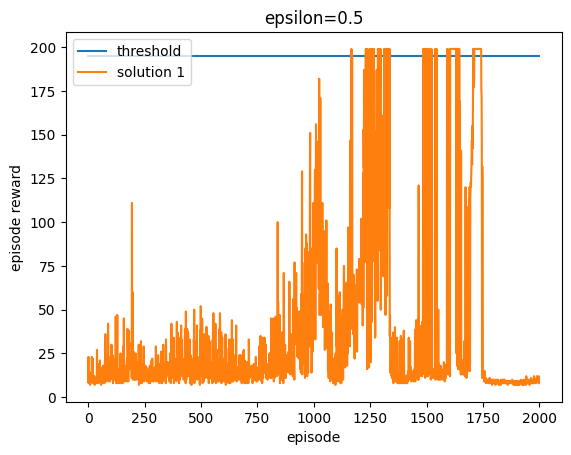

done


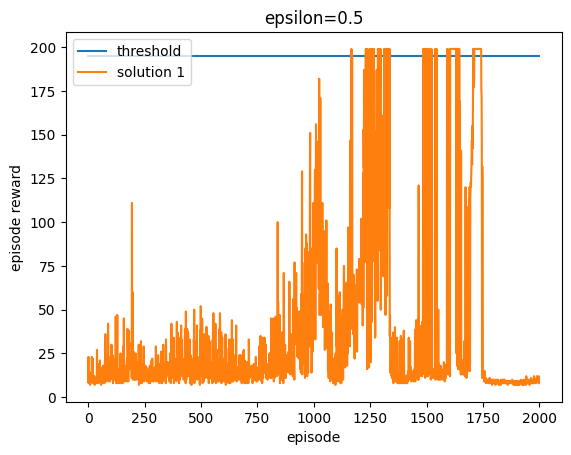

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # gready threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 8
model = PG(n_states, n_actions, n_hidden, alpha)

#
memory = []
replay_size = 10
episode_rewards = []
batch_actions = []
batch_size = 50
batch_weights = []
returns = []
lengths = []
batch_states = []
epochs = 0
# Q-learning
for i_episode in range(EPISODES_MAX):
    episode_rewards = []
    observation = env.reset()

    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:

        plt.figure(2)
        plt.clf()

        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        action = model.get_action(state)
        observation, reward, done, info = env.step(action)
        
        next_state = observation
        
        batch_states.append(state)
        batch_actions.append(action)
        episode_rewards.append(reward)
        if done:
            total_return = sum(episode_rewards)
            episode_length = len(episode_rewards)
            batch_weights+= [total_return]*episode_length


            returns.append(total_return)
            lengths.append(episode_length)
            
            #log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
        state = next_state
        # Update Policy
    if len(batch_states)>batch_size:
        epochs+= 1
        model.update(batch_states, batch_actions, batch_weights)
        batch_states = []
        batch_actions = []
        batch_weights = []
        episode_rewards = []

        # Update current state 
        

    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")

SPG + reward to go

In [ ]:
def reward_to_go(rews):
  n = len(rews)
  rtgs = np.zeros_like(rews)
  for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
  return rtgs

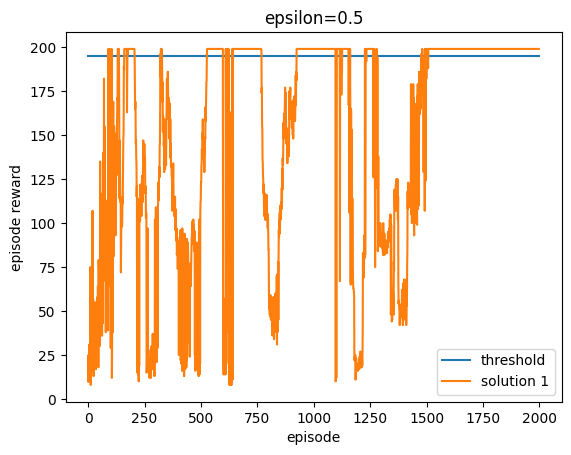

done


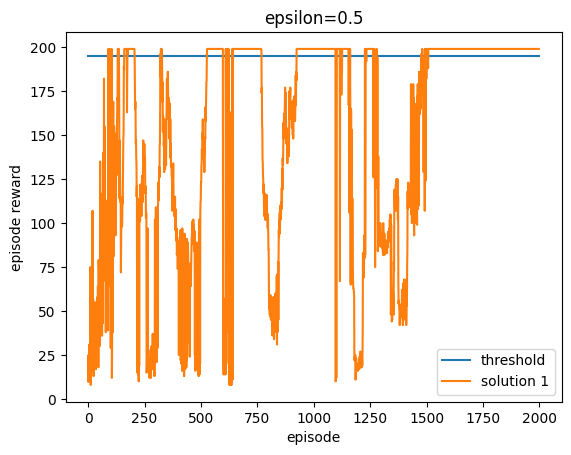

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # gready threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 8
model = PG(n_states, n_actions, n_hidden, alpha)

#
memory = []
replay_size = 10
episode_rewards = []
batch_actions = []
batch_size = 50
batch_weights = []
returns = []
lengths = []
batch_states = []
epochs = 0
# Q-learning
for i_episode in range(EPISODES_MAX):
    episode_rewards = []
    observation = env.reset()

    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:

        plt.figure(2)
        plt.clf()

        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}'.format(epsilon))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        action = model.get_action(state)
        observation, reward, done, info = env.step(action)
        
        next_state = observation
        
        batch_states.append(state)
        batch_actions.append(action)
        episode_rewards.append(reward)
        if done:
            total_return = sum(episode_rewards)
            episode_length = len(episode_rewards)
            batch_weights += list(reward_to_go(episode_rewards))

            returns.append(total_return)
            lengths.append(episode_length)
            
            #log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
        state = next_state
        # Update Policy
    if len(batch_states)>batch_size:
        epochs+= 1
        model.update(batch_states, batch_actions, batch_weights)
        batch_states = []
        batch_actions = []
        batch_weights = []
        episode_rewards = []

        # Update current state 
        

    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")

SPG + reward to go + scheduler

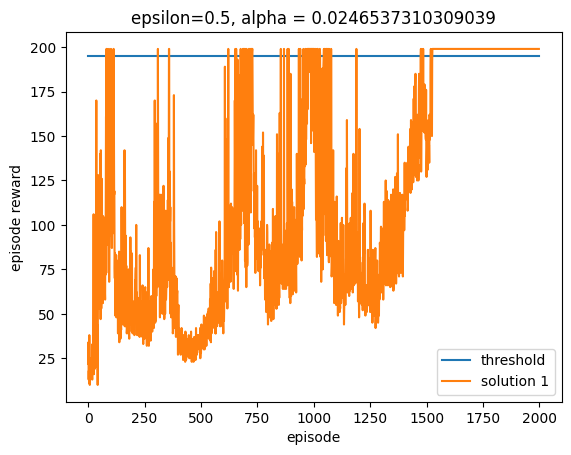

done


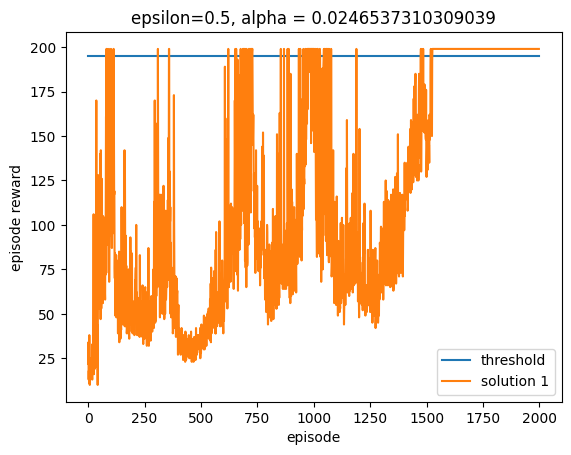

In [ ]:
from torch.optim.lr_scheduler import StepLR
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 0.5 # gready threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 8
model = PG(n_states, n_actions, n_hidden, alpha)
scheduler = StepLR(model.optimizer, 
                   step_size = 50, # Period of learning rate decay
                   gamma = 0.98) 
#
memory = []
replay_size = 10
episode_rewards = []
batch_actions = []
batch_size = 50
batch_weights = []
returns = []
lengths = []
batch_states = []
epochs = 0
# Q-learning
for i_episode in range(EPISODES_MAX):
    episode_rewards = []
    observation = env.reset()

    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:

        plt.figure(2)
        plt.clf()

        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={}, alpha = {}'.format(epsilon,model.optimizer.param_groups[0]["lr"]))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    for t in range(STEPS_MAX):   
        action = model.get_action(state)
        observation, reward, done, info = env.step(action)
        
        next_state = observation
        
        batch_states.append(state)
        batch_actions.append(action)
        episode_rewards.append(reward)
        if done:
            total_return = sum(episode_rewards)
            episode_length = len(episode_rewards)
            batch_weights += list(reward_to_go(episode_rewards))

            returns.append(total_return)
            lengths.append(episode_length)
            
            #log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break
        state = next_state
        # Update Policy
    if len(batch_states)>batch_size:
        epochs+= 1
        model.update(batch_states, batch_actions, batch_weights)
        scheduler.step()  
        batch_states = []
        batch_actions = []
        batch_weights = []
        episode_rewards = []

        # Update current state 
     

    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
            

print("done")